### Cross validation over PHUS

We are asuming that all the observations within the stations from the same PHU are 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from gee_scripts.parameters import explain_vars, response_var, regions_ids
from scipy.stats import pearsonr
from gee_scripts.models import get_random_forest, get_regressors
import tensorflow as tf
from sklearn.discriminant_analysis import StandardScaler
from gee_scripts.models import split_dataset

from typing import Literal

region: Literal["sumatra", "kalimantan", "eastern", "all"]

Earth Engine initialized successfully, with ee-indonesia-gwl


2024-06-26 16:07:47.141002: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 16:07:47.142647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 16:07:47.171563: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 16:07:47.172298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 16:07:47.661996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## User parameters

In [3]:
# USER PARAMETERS

# Select the region where to work
region = "kalimantan"

## List of specific id values to remove
# These stations were selected based on the results of the previous analysis
bad_stations = ['batok1','batok2','brg11','brg13','brg16','BRG_620309_01','BRG_620309_02','BRG_630805_01','BRG_630708_01']

## Data definition

In [4]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
df = df.sort_values("date")
assert len(df) == 32783, "The length of the dataframe is not correct" # Check that the length of the dataframe is correct
assert df[["date"]].dtypes.iloc[0] == "datetime64[ns]" # Check that the date column is a datetime


df = df[df.region_id.isin(regions_ids[region])]
print(f"Using region {region}, with {len(df)} rows")

Using region kalimantan, with 6063 rows


In [5]:
# Remove the bad stations
print("Bad stations accounted for:", len(df[df["id"].isin(bad_stations)]))

# Remove the bad stations
df = df[~df["id"].isin(bad_stations)]

# print the number of data after removing the bad stations
print(f"Using region {region}, with {len(df)} rows")

Bad stations accounted for: 267
Using region kalimantan, with 5796 rows


<Axes: xlabel='region_id', ylabel='gwl_cm'>

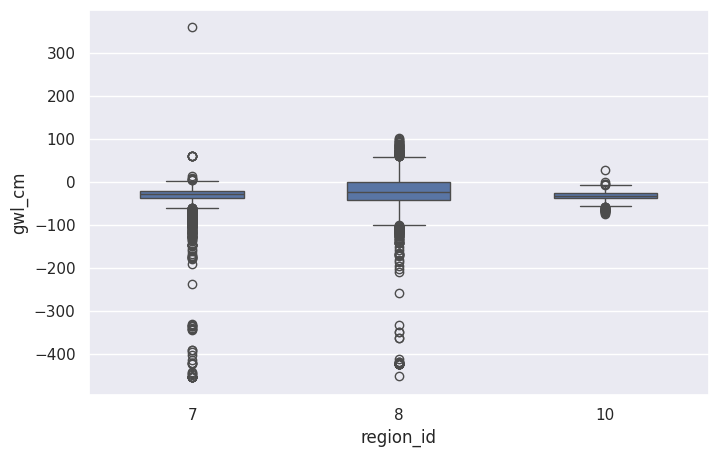

In [6]:
import seaborn as sns
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid");
sns.set(rc={'figure.figsize':(8,5)});
sns.boxplot(x="region_id", y="gwl_cm", data=df, width=0.5)

<Axes: xlabel='date', ylabel='gwl_cm'>

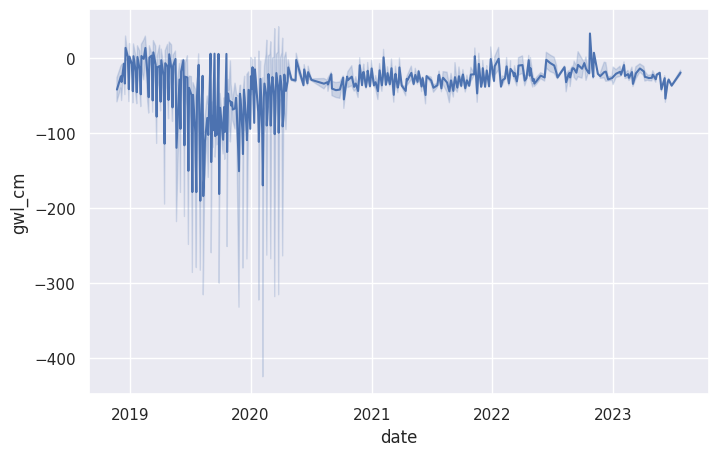

In [7]:
sns.lineplot(x="date", y="gwl_cm", data=df)

In [24]:
def evaluate_models(data, target_column, n_splits):
    """Evaluate the performance of different regression models on the dataset using cross-validation."""
    print("Evaluating model")
    data = data.copy()

    results = []
    
    # Loop through each split type
    for split_type in ["station", "year", "month", "observation"]:

        train_test_splits = split_dataset(data, by=split_type, n_splits=n_splits)
        split_name = split_type

        if split_type == "station":
            split_type = "id"
            split_name = "station"

        if split_type == "observation":
            split_type = "index"
            split_name = "index"
            

        for train_data, test_data in train_test_splits:

            if len(test_data) == 0:
                results.append({
                    "phu_id": data["phu_id"].iloc[0],
                    "split_type": split_type,
                    "no_obs": len(data),
                    "train_obs": 0,
                    "test_obs": 0,
                    "estimator_name": None,
                    "validation" : f"cross validation {split_type}",
                    "test_ids": None,
                    "train_ids": None,
                    "r2_score": None,
                    "rmse": None,
                    "pearson_r": None,
                    "p_value": None,
                })
                continue
            
            X_train, X_test = train_data[explain_vars], test_data[explain_vars]
            y_train, y_test = train_data[target_column], test_data[target_column]

            input_dim = X_train.shape[1]  # Number of explanatory variables

            for regr in get_regressors(input_dim):
                print(f"Training {regr.__class__.__name__} on {len(train_data)} observations and testing on {len(test_data)} observations")

                if isinstance(regr, tf.keras.Model):  # Check if the model is a Keras model
                    # Neural network requires normalization and batch processing
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    
                    # Fit the model
                    regr.fit(X_train_scaled, y_train, epochs=5, batch_size=8, verbose=0)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test_scaled).flatten()  # Flatten to convert 2D predictions to 1D
                else:
                    # Fit traditional models
                    regr.fit(X_train, y_train)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test)


                r, p = pearsonr(y_test, y_pred_test)
                r2_score_val = r2_score(y_test, y_pred_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

                print("Model trained and tested")

                results.append({
                    "phu_id": train_data["phu_id"].iloc[0],
                    "no_obs": len(data),
                    "train_obs": len(train_data),
                    "test_obs": len(test_data),
                    "estimator_name": regr.__class__.__name__,
                    "validation" : f"cross validation {split_name}",
                    "train_ids": train_data[split_type].unique(),
                    "test_ids": test_data[split_type].unique(),
                    "r2_score": r2_score_val,
                    "rmse": rmse,
                    "pearson_r": r,
                    "p_value": p,
                })
    print("Model evaluation complete")
    return results

In [25]:
%%time
phu_cross_validation_results = []
failed_phus = []
errors = {}

print(f"running cross validation on {df.phu_id.nunique()} phu_ids")

for phu_id in df.phu_id.unique():
    if  pd.isnull(phu_id):
        print("Skipping phu_id", phu_id, "because it is null")
        continue
    print("processing phu_id", phu_id, "with No. of observations", len(df[df.phu_id==phu_id]))
    filter_condition = df.phu_id==phu_id
    train_df = df[filter_condition]

    try:
        results = evaluate_models(train_df, "gwl_cm", n_splits=10)
        phu_cross_validation_results.extend(results)
    except Exception as e:
        print("####### Failed to train model on phu_id", phu_id)
        errors[phu_id] = e
        failed_phus.append(phu_id)
        raise e
    finally:
        continue

running cross validation on 23 phu_ids
processing phu_id 297.0 with No. of observations 159
Evaluating model
Splitting by station with 159 samples
test 41 train 118
test 41 train 118
test 41 train 118
test 41 train 118
test 36 train 123
test 41 train 118
test 41 train 118
test 41 train 118
test 41 train 118
test 41 train 118
Training RandomForestRegressor on 118 observations and testing on 41 observations
Model trained and tested
Training GradientBoostingRegressor on 118 observations and testing on 41 observations
Model trained and tested
Training LinearRegression on 118 observations and testing on 41 observations
Model trained and tested
Training Sequential on 118 observations and testing on 41 observations
2/2 [==============================] - 0s 2ms/step
Model trained and tested
Training RandomForestRegressor on 118 observations and testing on 41 observations
Model trained and tested
Training GradientBoostingRegressor on 118 observations and testing on 41 observations
Model trained

In [26]:
len(phu_cross_validation_results)

2100

In [27]:
errors

{219.0: ValueError('With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.'),
 356.0: ValueError('With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.'),
 370.0: ValueError('With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.'),
 382.0: ValueError('With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.')}

In [28]:
failed_phus

[219.0, 356.0, 370.0, 382.0]

In [29]:
# Create a dataframe from the results
results_df = pd.DataFrame(phu_cross_validation_results)
# Sort the results by r2_score and phu_id
results_df.sort_values(by=["r2_score", "phu_id"], ascending=False, inplace=True)
results_df.to_csv("data/13_estimation_results/kalimantan_multiple_models_cross_validation_results_sorted.csv", index=False)